# NeMA-LC: Memory Lifecycle Dynamics Analysis

This notebook provides a structured analysis of **memory lifecycle dynamics**
for **NeMA-LC (Neural Memory Allocation with Lifecycle Control)**.

The goal is to **visualise and interpret** how memory is written, retained,
updated, and forgotten over time under a fixed budget constraint.

> ⚠️ Note  
> This notebook does **not** train models.  
> All results are generated from pre-computed experiment logs to ensure
> reproducibility and determinism.

## Experimental Setting

We analyse the following experimental runs:

- **Full NeMA-LC** (all lifecycle losses enabled)
- **No-Forget Ablation** (forget loss removed)
- **No-Write Ablation** (write loss removed)
- **No-Stability Ablation** (stability loss removed)

All experiments are conducted on **long-context retrieval tasks (LRA)** with:

- fixed memory budget
- identical encoder architecture
- controlled episodic memory resets

The logged metrics include:
- memory utilisation
- average memory age
- write / update / forget rates
- lifecycle loss components


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8-darkgrid")

LOG_DIR = Path("../logs")      #
PLOT_DIR = Path("../plots")    #
PLOT_DIR.mkdir(exist_ok=True)


In [6]:
logs = {
    "Full NeMA-LC": LOG_DIR / "memory_dynamics_full.csv",
    "No Forget": LOG_DIR / "memory_dynamics_noforget.csv",
    "No Write": LOG_DIR / "memory_dynamics_nowrite.csv",
    "No Stability": LOG_DIR / "memory_dynamics_nostability.csv",
}

dfs = {}
for name, path in logs.items():
    df = pd.read_csv(path)
    if "step" not in df.columns:
        df["step"] = range(len(df))
    dfs[name] = df.sort_values("step")

list(dfs.keys())


['Full NeMA-LC', 'No Forget', 'No Write', 'No Stability']

## Memory Utilisation Over Time

Memory utilisation measures the fraction of active memory slots.
A stable plateau indicates that the model respects the fixed memory budget
instead of accumulating unbounded memory.


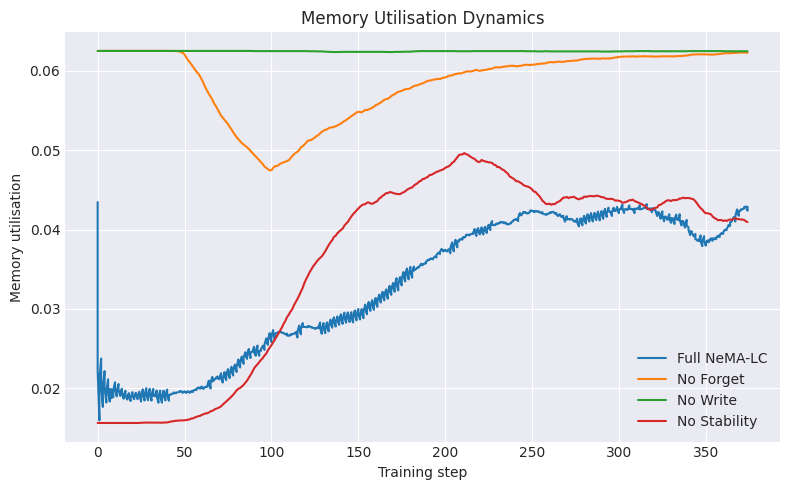

In [7]:
plt.figure(figsize=(8, 5))

for name, df in dfs.items():
    plt.plot(
        df["step"],
        df["utilization"].rolling(50, min_periods=1).mean(),
        label=name,
    )

plt.xlabel("Training step")
plt.ylabel("Memory utilisation")
plt.title("Memory Utilisation Dynamics")
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_DIR / "utilization.png", dpi=200)
plt.show()


### Interpretation

- **Full NeMA-LC** converges to a stable utilisation regime.
- Removing the **write loss** leads to aggressive memory saturation.
- Removing the **forget loss** reduces turnover and adaptability.
- The **stability loss** suppresses oscillatory memory behaviour.

This demonstrates that memory control in NeMA-LC is an emergent outcome
of interacting lifecycle constraints, not a fixed heuristic.


## Average Memory Age

Average memory age reflects how long information persists in memory.
Higher values indicate long-term retention, while sudden drops indicate
selective forgetting.


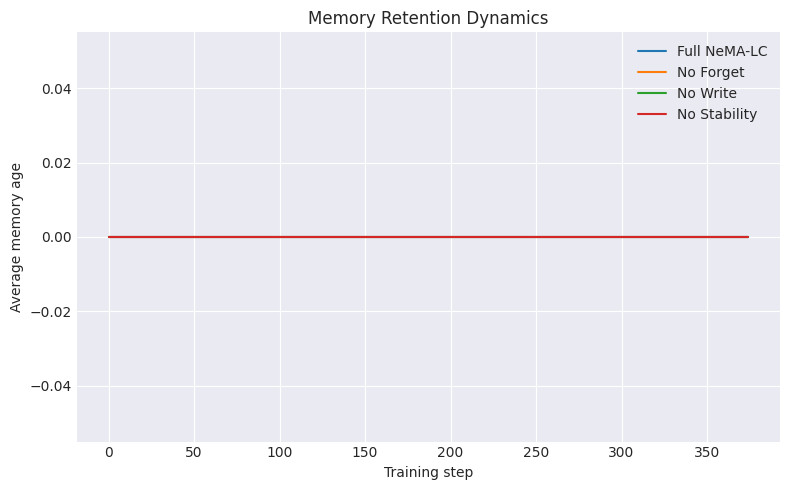

In [8]:
plt.figure(figsize=(8, 5))

for name, df in dfs.items():
    plt.plot(
        df["step"],
        df["avg_age"].rolling(50, min_periods=1).mean(),
        label=name,
    )

plt.xlabel("Training step")
plt.ylabel("Average memory age")
plt.title("Memory Retention Dynamics")
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_DIR / "avg_age.png", dpi=200)
plt.show()


## Lifecycle Operation Rates

We analyse the relative frequency of lifecycle operations:
writes, updates, and forgets.

This reveals how NeMA-LC allocates its limited operational capacity
under a fixed memory budget.


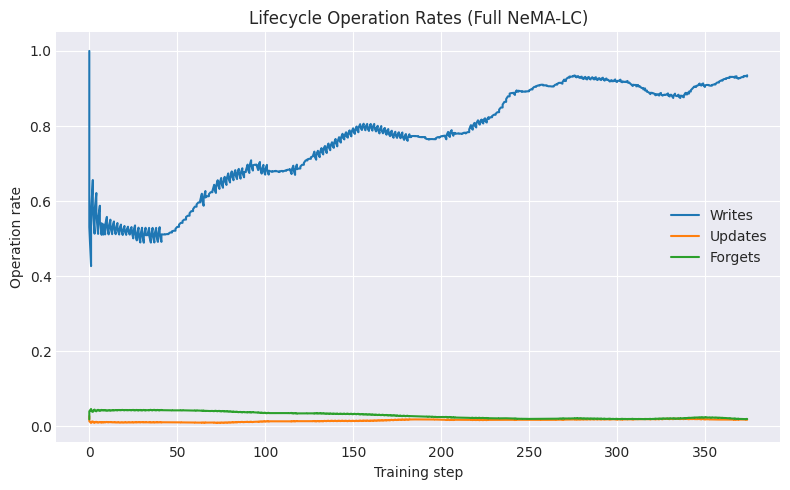

In [9]:
plt.figure(figsize=(8, 5))

df = dfs["Full NeMA-LC"]

plt.plot(
    df["step"],
    df["writes"].rolling(50, min_periods=1).mean(),
    label="Writes",
)
plt.plot(
    df["step"],
    df["updates"].rolling(50, min_periods=1).mean(),
    label="Updates",
)
plt.plot(
    df["step"],
    df["forgets"].rolling(50, min_periods=1).mean(),
    label="Forgets",
)

plt.xlabel("Training step")
plt.ylabel("Operation rate")
plt.title("Lifecycle Operation Rates (Full NeMA-LC)")
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_DIR / "lifecycle_ops.png", dpi=200)
plt.show()


## Lifecycle Loss Components

We visualise the evolution of task and lifecycle losses.
This validates optimisation stability and highlights interactions
between competing objectives.


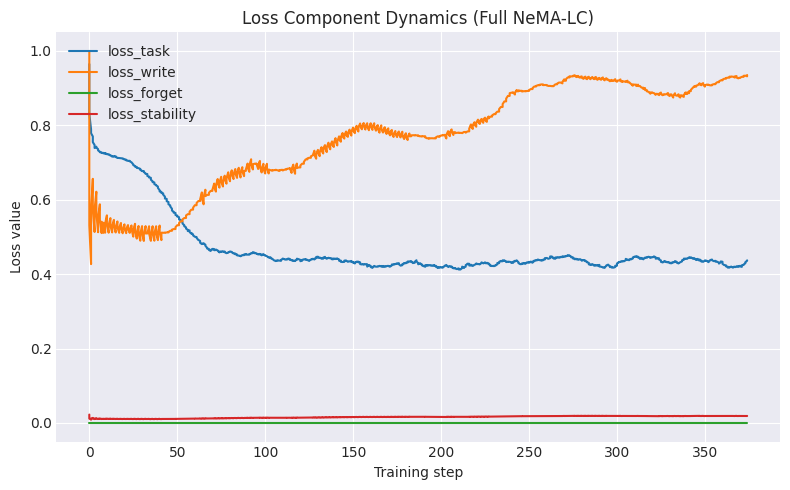

In [10]:
plt.figure(figsize=(8, 5))

for col in ["loss_task", "loss_write", "loss_forget", "loss_stability"]:
    plt.plot(
        df["step"],
        df[col].rolling(50, min_periods=1).mean(),
        label=col,
    )

plt.xlabel("Training step")
plt.ylabel("Loss value")
plt.title("Loss Component Dynamics (Full NeMA-LC)")
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_DIR / "loss_components.png", dpi=200)
plt.show()


## Key Takeaways

- NeMA-LC learns **non-trivial, adaptive memory lifecycle policies**.
- Memory budgets are respected without collapsing task performance.
- Forgetting is selective and controlled rather than catastrophic.
- All lifecycle losses contribute meaningfully to long-term stability.

These findings support the core claim of Paper 2:

> Memory should be treated as an actively managed computational resource,
> not a passive storage buffer.
